# Online Logistic Regression using CMGF

Online training of a logistic regression model using conditional moments Gaussian filter (CMGF).

We compare the CMGF result with Laplace approximation of the posterior.


Authors: Peter G. Chang ([@petergchang](https://github.com/petergchang)), Gerardo Durán-Martín ([@gerdm](https://github.com/gerdm))

## 0. Imports

In [3]:
try:
    from dynamax.cond_moments_gaussian_filter.cmgf import *
    from dynamax.cond_moments_gaussian_filter.generalized_gaussian_ssm import *
except ModuleNotFoundError:
    print('installing dynamax')
    %pip install -qq git+https://github.com/probml/dynamax.git
    from dynamax.cond_moments_gaussian_filter.cmgf import *
    from dynamax.cond_moments_gaussian_filter.generalized_gaussian_ssm import *

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.scipy.optimize import minimize

## 1. Simulation and Plotting

We generate a reasonable 2d binary classification data.

In [5]:
def generate_dataset(num_points=1000, shuffle=True, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    key0, key1, key2 = jr.split(key, 3)

    # Generate standardized noisy inputs that correspond to output '0'
    num_zero_points = num_points // 2
    zero_input = jnp.array([[-1., -1.]] * num_zero_points)
    zero_input += jr.normal(key0, (num_zero_points, 2))

    # Generate standardized noisy inputs that correspond to output '1'
    num_one_points = num_points - num_zero_points
    one_input = jnp.array([[1., 1.]] * num_one_points)
    one_input += jr.normal(key1, (num_one_points, 2))

    # Stack the inputs and add bias term
    input = jnp.concatenate([zero_input, one_input])
    input_with_bias = jnp.concatenate([jnp.ones((num_points, 1)), input], axis=1)

    # Generate binary output
    output = jnp.concatenate([jnp.zeros((num_zero_points)), jnp.ones((num_one_points))])

    # Shuffle
    if shuffle:
        idx = jr.shuffle(key2, jnp.arange(num_points))
        input, input_with_bias, output = input[idx], input_with_bias[idx], output[idx]
    
    return input, input_with_bias, output

In [6]:
# Generate data
input, input_with_bias, output = generate_dataset()

/opt/homebrew/lib/python3.9/site-packages/jax/_src/random.py:399: FutureWarning: jax.random.shuffle is deprecated and will be removed in a future release. Use jax.random.permutation with independent=True.
  warnings.warn(msg, FutureWarning)


Next, we define a function that visualizes the 2d posterior predictive distribution.

In [7]:
def plot_posterior_predictive(ax, X, title, colors, Xspace=None, Zspace=None, cmap="viridis"):
    if Xspace is not None and Zspace is not None:
        ax.contourf(*Xspace, Zspace, cmap=cmap, levels=20)
        ax.axis('off')
    ax.scatter(*X.T, c=colors, edgecolors='gray', s=50)
    ax.set_title(title)
    plt.tight_layout()

In [8]:
def plot_boundary(ax, X, colors, Xspace, w):
    ax.scatter(*X.T, c=colors, edgecolors='gray', s=50)
    ax.plot(Xspace[0], -w[1]/w[2] * Xspace[0] - w[0]/w[2])
    plt.tight_layout()

Let's look at our binary data in 2d.

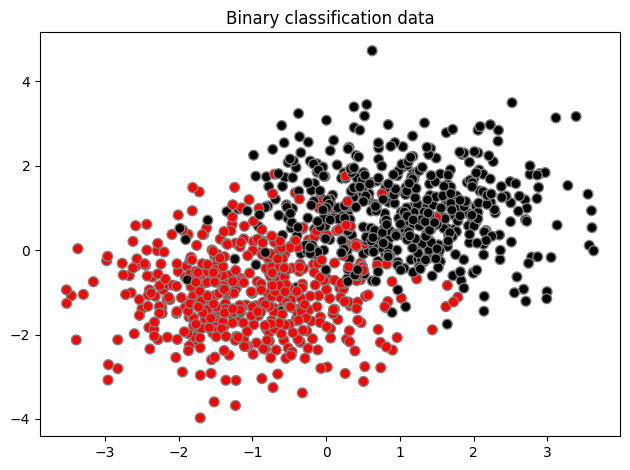

In [9]:
fig, ax = plt.subplots()

title = "Binary classification data"
colors = ['black' if y else 'red' for y in output]
plot_posterior_predictive(ax, input, title, colors )

Let us define a grid on which we compute the predictive distribution.

In [10]:
# Define grid limits
xmin, ymin = input.min(axis=0) - 0.1
xmax, ymax = input.max(axis=0) + 0.1

# Define grid
step = 0.1
input_grid = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = input_grid.shape
input_with_bias_grid = jnp.concatenate([jnp.ones((1, nx, ny)), input_grid])

Next, we define a function to that returns the posterior predictive probability for each point in grid.

In [11]:
def posterior_predictive_grid(grid, mean, cov, n_samples=5000, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    samples = jax.random.multivariate_normal(key, mean, cov, (n_samples,))
    Z = jax.nn.sigmoid(jnp.einsum("mij,sm->sij", grid, samples))
    Z = Z.mean(axis=0)
    return Z

Finally, we define a function that plots the convergence of filtered estimates to Laplace batch estimate.

In [12]:
def plot_cmgf_post_laplace(
    mean_hist, cov_hist, w_laplace, lcolors, filter_type, legend_font_size=14, bb1=(1.1, 1.1), bb2=(1.1, 0.3), bb3=(0.8, 0.3)
):
    input_dim = mean_hist.shape[-1]
    tau_hist = jnp.array([cov_hist[:, i, i] for i in range(input_dim)]).T
    elements = (mean_hist.T, tau_hist.T, w_laplace, lcolors)
    n_datapoints = len(mean_hist)
    timesteps = jnp.arange(n_datapoints) + 1

    for k, (wk, Pk, wk_fix, c) in enumerate(zip(*elements)):
        fig_weight_k, ax = plt.subplots()
        ax.errorbar(timesteps, wk, jnp.sqrt(Pk), c=c, label=f"$w_{k}$ online ({filter_type})")
        ax.axhline(y=wk_fix, c=c, linestyle="dotted", label=f"$w_{k}$ batch (Laplace)", linewidth=3)

        ax.set_xlim(1, n_datapoints)

        ax.set_xlabel("ordered sample number", fontsize=15)
        ax.set_ylabel("weight value", fontsize=15)
        ax.tick_params(axis="both", which="major", labelsize=15)
        sns.despine()
        if k == 0:
            ax.legend(frameon=False, loc="upper right", bbox_to_anchor=bb1, fontsize=legend_font_size)

        elif k == 1:
            ax.legend(frameon=False, bbox_to_anchor=bb2, fontsize=legend_font_size)

        elif k == 2:
            ax.legend(frameon=False, bbox_to_anchor=bb3, fontsize=legend_font_size)

        plt.tight_layout()

## 2. Laplace Estimate

We compute the Laplace-approximation posterior for comparison.

In [13]:
def log_posterior(w, X, Y, prior_var):
    prediction = jax.nn.sigmoid(X @ w)
    log_prior = -(prior_var * w @ w / 2)
    log_likelihood = Y * jnp.log(prediction) + (1 - Y) * jnp.log(1 - prediction)
    return log_prior + log_likelihood.sum()

def laplace_inference(X, Y, prior_var=2.0, key=0):
    if isinstance(key, int):
        key = jr.PRNGKey(key)
    input_dim = X.shape[-1]

    # Initial random guess
    w0 = jr.multivariate_normal(key, jnp.zeros(input_dim), jnp.eye(input_dim) * prior_var)
    
    # Energy function to minimize
    E = lambda w: -log_posterior(w, X, Y, prior_var) / len(Y)

    # Minimize energy function
    w_laplace = minimize(E, w0, method="BFGS").x
    cov_laplace = jax.hessian(E)(w_laplace)

    return w_laplace, cov_laplace

In [14]:
# Compute Laplace posterior
prior_var = 1.0
w_laplace, cov_laplace = laplace_inference(input_with_bias, output, prior_var=prior_var)

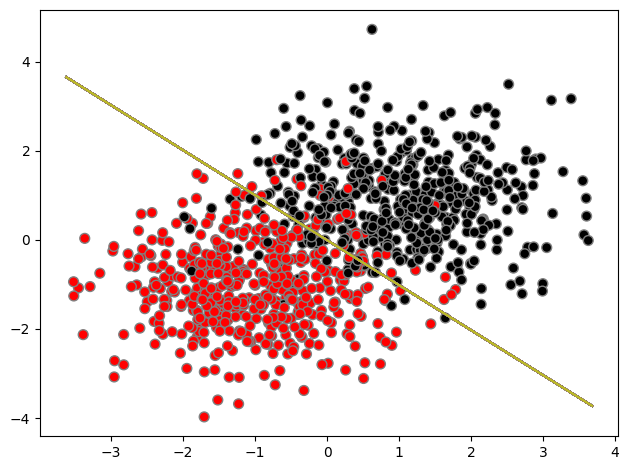

In [15]:
fig_adf, ax = plt.subplots()

plot_boundary(ax, input, colors, input_grid, w_laplace)

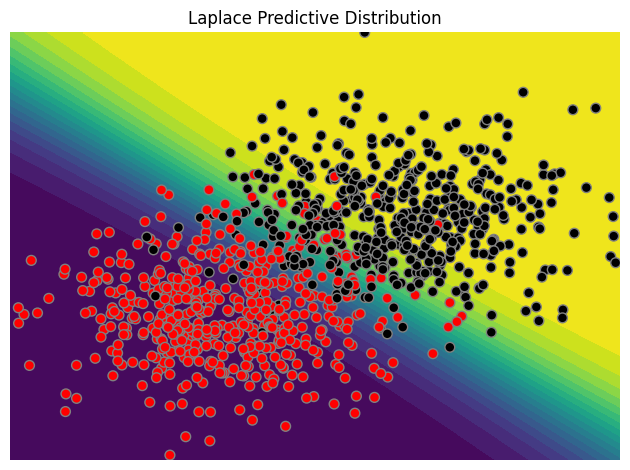

In [16]:
fig_adf, ax = plt.subplots()

# Plot Laplace posterior predictive distribution
Z_laplace = posterior_predictive_grid(input_with_bias_grid, w_laplace, cov_laplace)
title = "Laplace Predictive Distribution"
plot_posterior_predictive(ax, input, title, colors, input_grid, Z_laplace)

## 3. CMGF Estimates

First, we compute the posterior using CMGF-EKF.

In [19]:
input_dim = input_with_bias.shape[-1]
sigmoid_fn = lambda w, x: jax.nn.sigmoid(w @ x)

# Initial parameters for all CMGF methods
initial_mean, initial_covariance = jnp.zeros(input_dim), prior_var * jnp.eye(input_dim)
dynamics_function = lambda w, x: w
dynamics_covariance = jnp.zeros((input_dim, input_dim))
emission_mean_function = sigmoid_fn
emission_cov_function = lambda w, x: sigmoid_fn(w, x) * (1 - sigmoid_fn(w, x))

In [22]:
cmgf_params = GGSSMParams(
    initial_mean = initial_mean,
    initial_covariance = initial_covariance,
    dynamics_function = dynamics_function,
    dynamics_covariance = dynamics_covariance,
    emission_mean_function = emission_mean_function,
    emission_cov_function = emission_cov_function
)

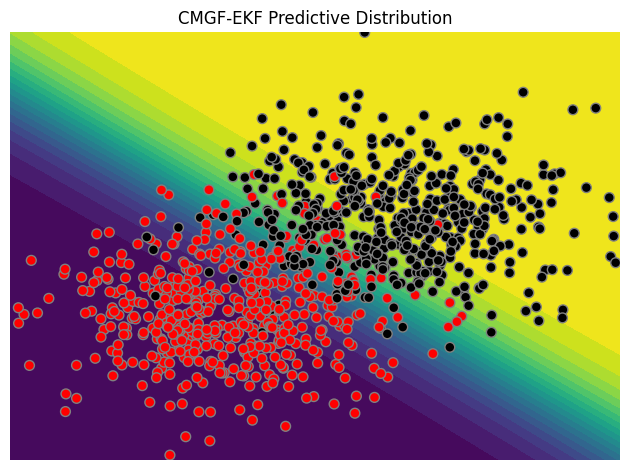

In [23]:
# Run CMGF-EKF and extract final estimates for moments
ekf_post = conditional_moments_gaussian_filter(cmgf_params, EKFIntegrals(), output, inputs = input_with_bias)
ekf_means, ekf_covs = ekf_post.filtered_means, ekf_post.filtered_covariances
w_ekf, cov_ekf = ekf_means[-1], ekf_covs[-1]

fig_adf, ax = plt.subplots()

# Plot posterior predictive distribution
Z_ekf = posterior_predictive_grid(input_with_bias_grid, w_ekf, cov_ekf)
title = "CMGF-EKF Predictive Distribution"
plot_posterior_predictive(ax, input, title, colors, input_grid, Z_ekf)

Next, we compute the posterior using CMGF-UKF

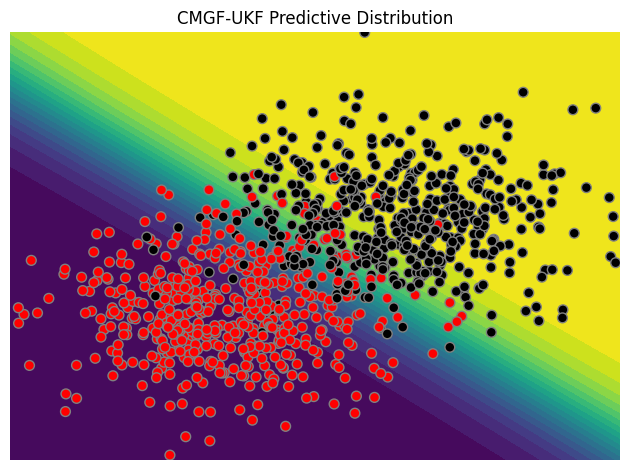

In [25]:
# Run CMGF-UKF and extract final estimates for moments
ukf_post = conditional_moments_gaussian_filter(cmgf_params, UKFIntegrals(), output, inputs = input_with_bias)
ukf_means, ukf_covs = ukf_post.filtered_means, ukf_post.filtered_covariances
w_ukf, cov_ukf = ukf_means[-1], ukf_covs[-1]

fig_adf, ax = plt.subplots()

# Plot posterior predictive distribution
Z_ukf = posterior_predictive_grid(input_with_bias_grid, w_ukf, cov_ukf)
title = "CMGF-UKF Predictive Distribution"
plot_posterior_predictive(ax, input, title, colors, input_grid, Z_ukf)

Finally, we compute the posterior using CMGF-GHKF

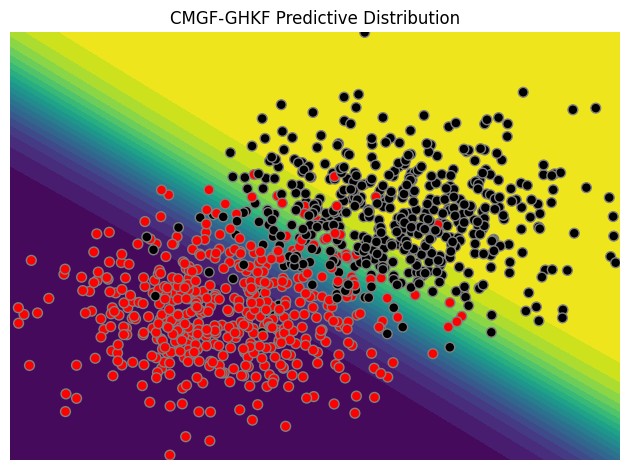

In [26]:
# Run CMGF-GHKF and extract final estimates for moments
ghkf_post = conditional_moments_gaussian_filter(cmgf_params, GHKFIntegrals(), output, inputs = input_with_bias)
ghkf_means, ghkf_covs = ghkf_post.filtered_means, ghkf_post.filtered_covariances
w_ghkf, cov_ghkf = ghkf_means[-1], ghkf_covs[-1]

fig_adf, ax = plt.subplots()

# Plot posterior predictive distribution
Z_ghkf = posterior_predictive_grid(input_with_bias_grid, w_ghkf, cov_ghkf)
title = "CMGF-GHKF Predictive Distribution"
plot_posterior_predictive(ax, input, title, colors, input_grid, Z_ghkf)

## 4. Inference over Time

Next, we will look at the convergence of the CMGF-inferred weights to the Laplace batch estimate.

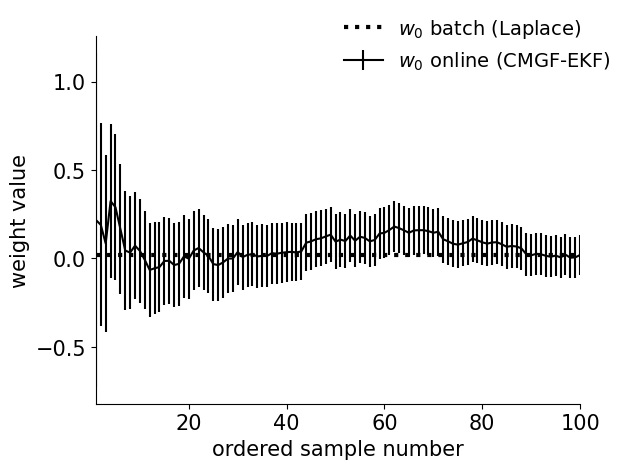

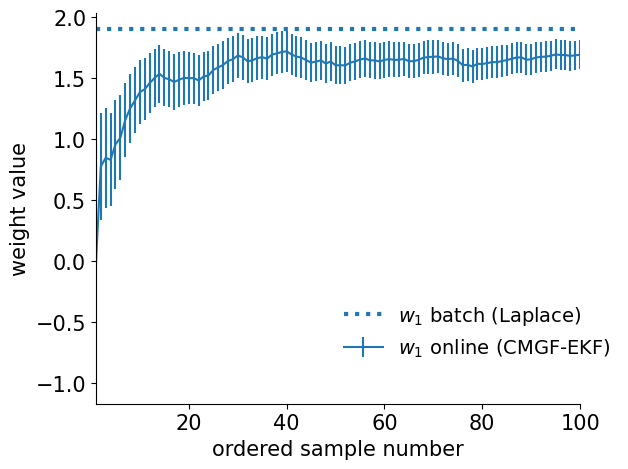

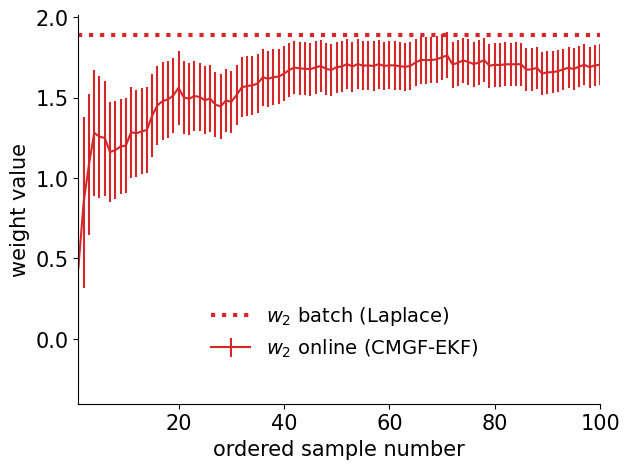

In [27]:
lcolors = ["black", "tab:blue", "tab:red"]

plot_cmgf_post_laplace(ekf_means[::max(1, len(output)//100)], ekf_covs[::max(1, len(output)//100)], w_laplace, lcolors, filter_type="CMGF-EKF")

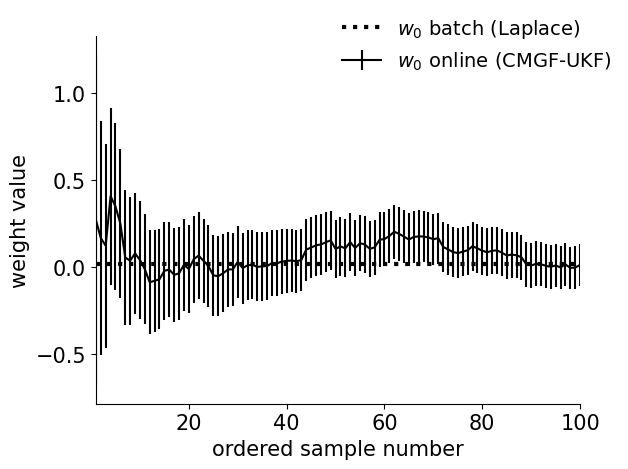

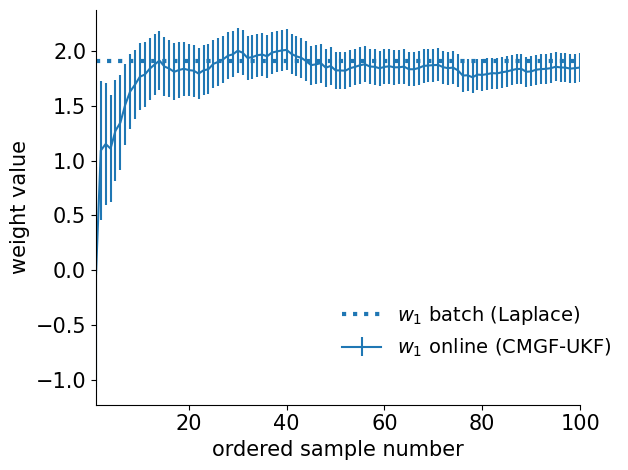

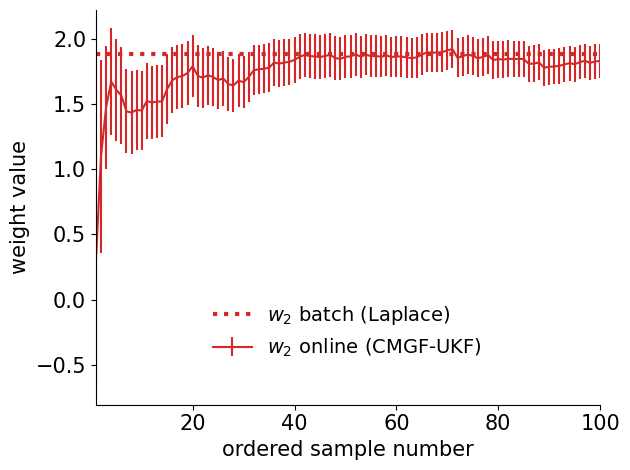

In [28]:
plot_cmgf_post_laplace(ukf_means[::max(1, len(output)//100)], ukf_covs[::max(1, len(output)//100)], w_laplace, lcolors, filter_type="CMGF-UKF")

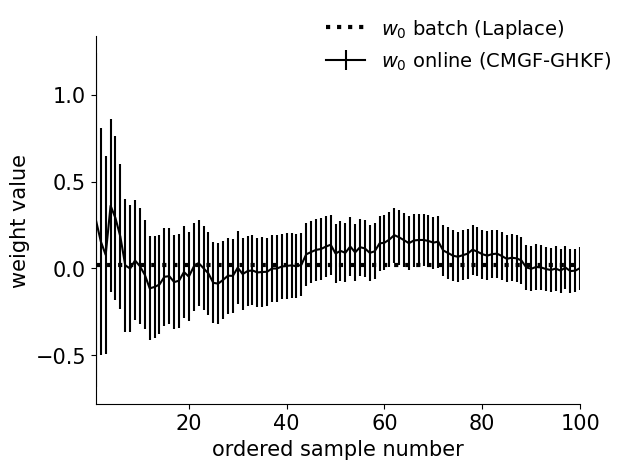

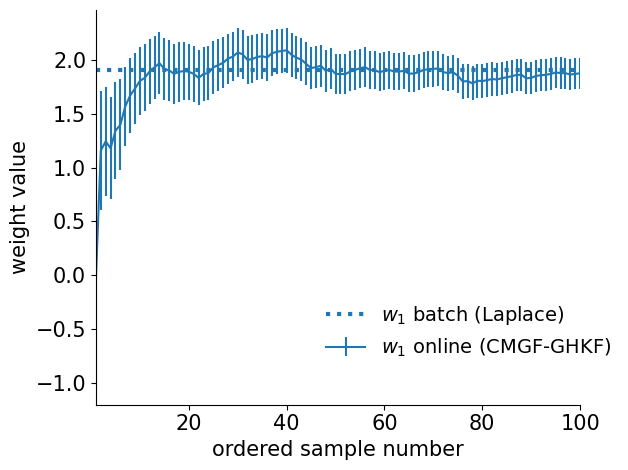

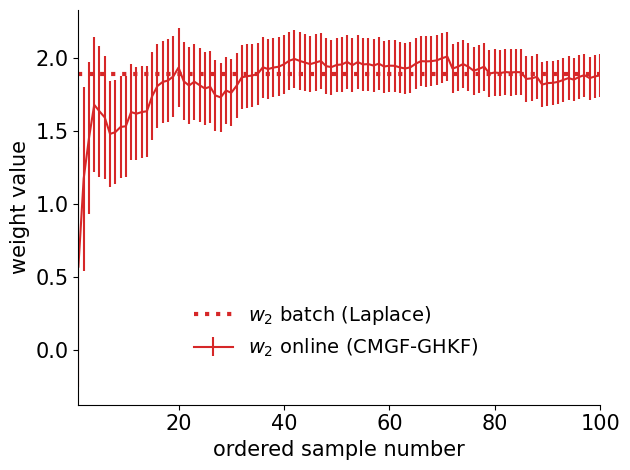

In [29]:
plot_cmgf_post_laplace(ghkf_means[::max(1, len(output)//100)], ghkf_covs[::max(1, len(output)//100)], w_laplace, lcolors, filter_type="CMGF-GHKF")